# some env variables

In [1]:
%set_env log_dir=/home/curlink/work/logs/

env: log_dir=/home/curlink/work/logs/


# pretraining from scratch
## preprocessors

In [2]:
from nn.data.preprocessors import RemoveEmojis, RemoveSymbols, RemoveHTML, AddPrefixWithProbability, ReplaceWithProbability

In [3]:
default_preprocessors = [
    RemoveEmojis(),
    RemoveHTML(),
    RemoveSymbols(["\\t", "\\r", "\a", "\b", "\f", "\t", "\v", "\r", "\n", "\\n", "/",
                   "\\a", "\\b", "\\f", "\\t", "\\v", "\\r", "//", "\\",
                   "[", "]", "\"", "`"]),
]

## data
### negative

In [4]:
import os
from torch.utils.data import Dataset, IterableDataset

from nn.data.parsers import parse_tg_json, parse_json_dict, parse_with_separator
from nn.data.datasets import ListDataset, ApplyFilter, spawn_clones, to_list_dataset, ApplyPreprocessors
from nn.data.filters import SkipShortStringsWithProbability
from nn.ensembles.dataset_ensembles import DatasetEnsemble

In [5]:
home_dir = "/home/curlink/work/datasets/"

def parse_tg_chats(path: str, json_dict=False, target_features=None, to_clone=None, out_styled=False, sep=None):
    path = os.path.join(home_dir, path)
    
    datasets = []
    names = []
    
    for name in os.listdir(path):
        if not (name.endswith('.json') or name.endswith('.out')):
            continue
        
        current = os.path.join(path, name)
        names.append(name[:-5])
        
        if json_dict:
            datasets.append(ListDataset(parse_json_dict(current, target_features=target_features)))
        elif out_styled:
            datasets.append(ListDataset(parse_with_separator(current, sep)))
        else:
            datasets.append(ListDataset(parse_tg_json(current)))
            
        if to_clone is not None and name[:-5] in to_clone.keys():
            datasets[-1] = spawn_clones(datasets[-1], times=to_clone[name[:-5]])
            
    return datasets, names

def filter_short(dataset: Dataset):
    min_length = 20  
    dataset = ApplyFilter(to_list_dataset(dataset), 
                            SkipShortStringsWithProbability(min_length=min_length, prob=0.9))
    return to_list_dataset(dataset)

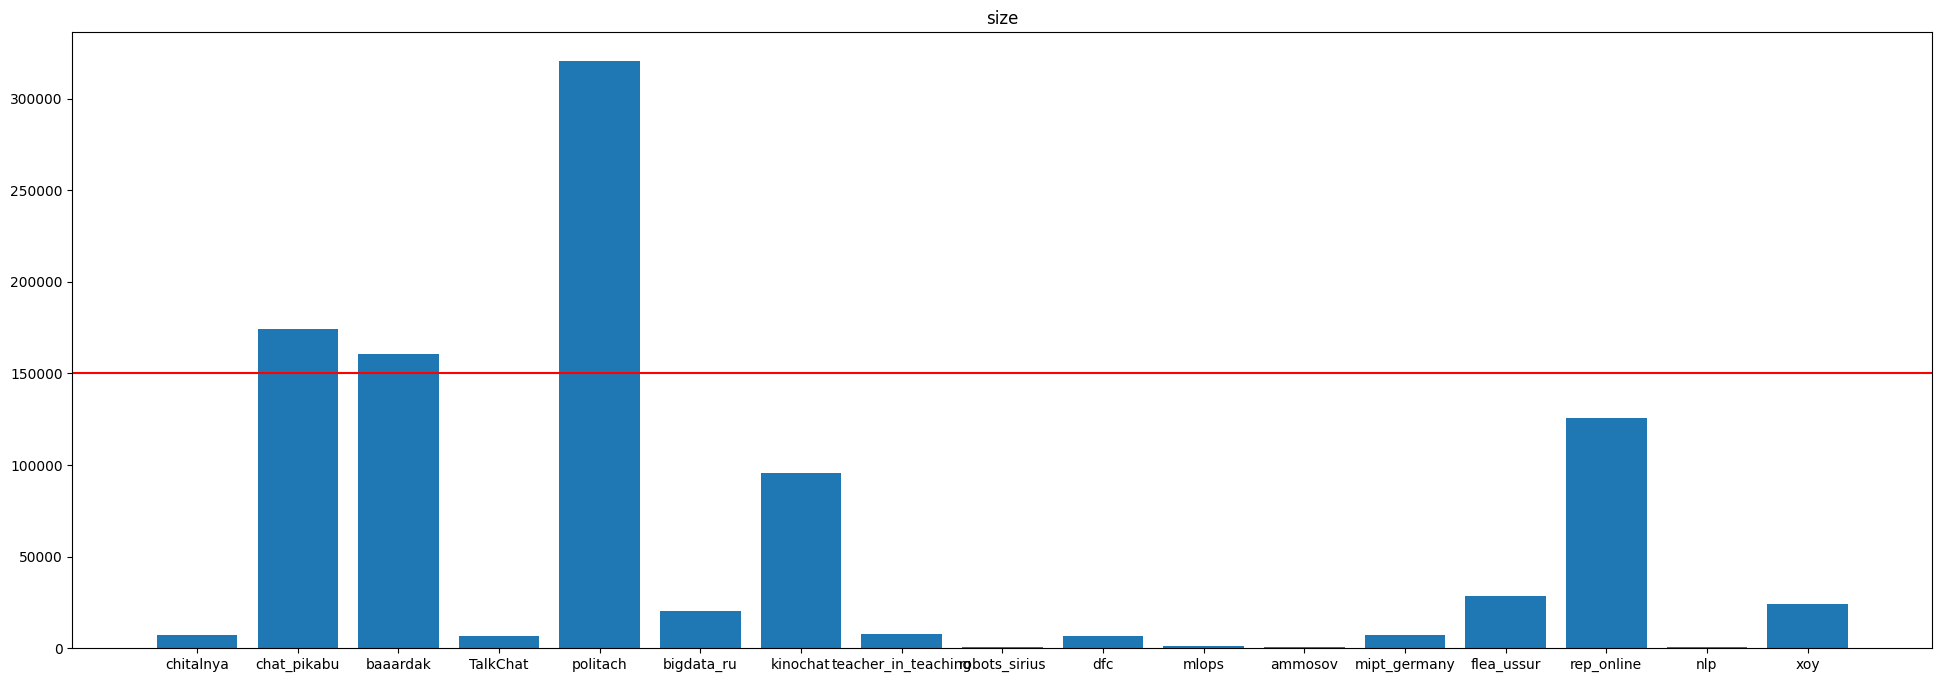

In [6]:
negative_ensemble = DatasetEnsemble([])
negative_ensemble.extend(*parse_tg_chats("message_classification/negative_tg_chats/russian_telegram_chats_history/",
                                        json_dict=True, target_features="text"))
negative_ensemble.extend(*parse_tg_chats("message_classification/negative_tg_chats/"))
negative_ensemble.datasets = [filter_short(x) for x in negative_ensemble.datasets]
negative_ensemble.clip(150000)

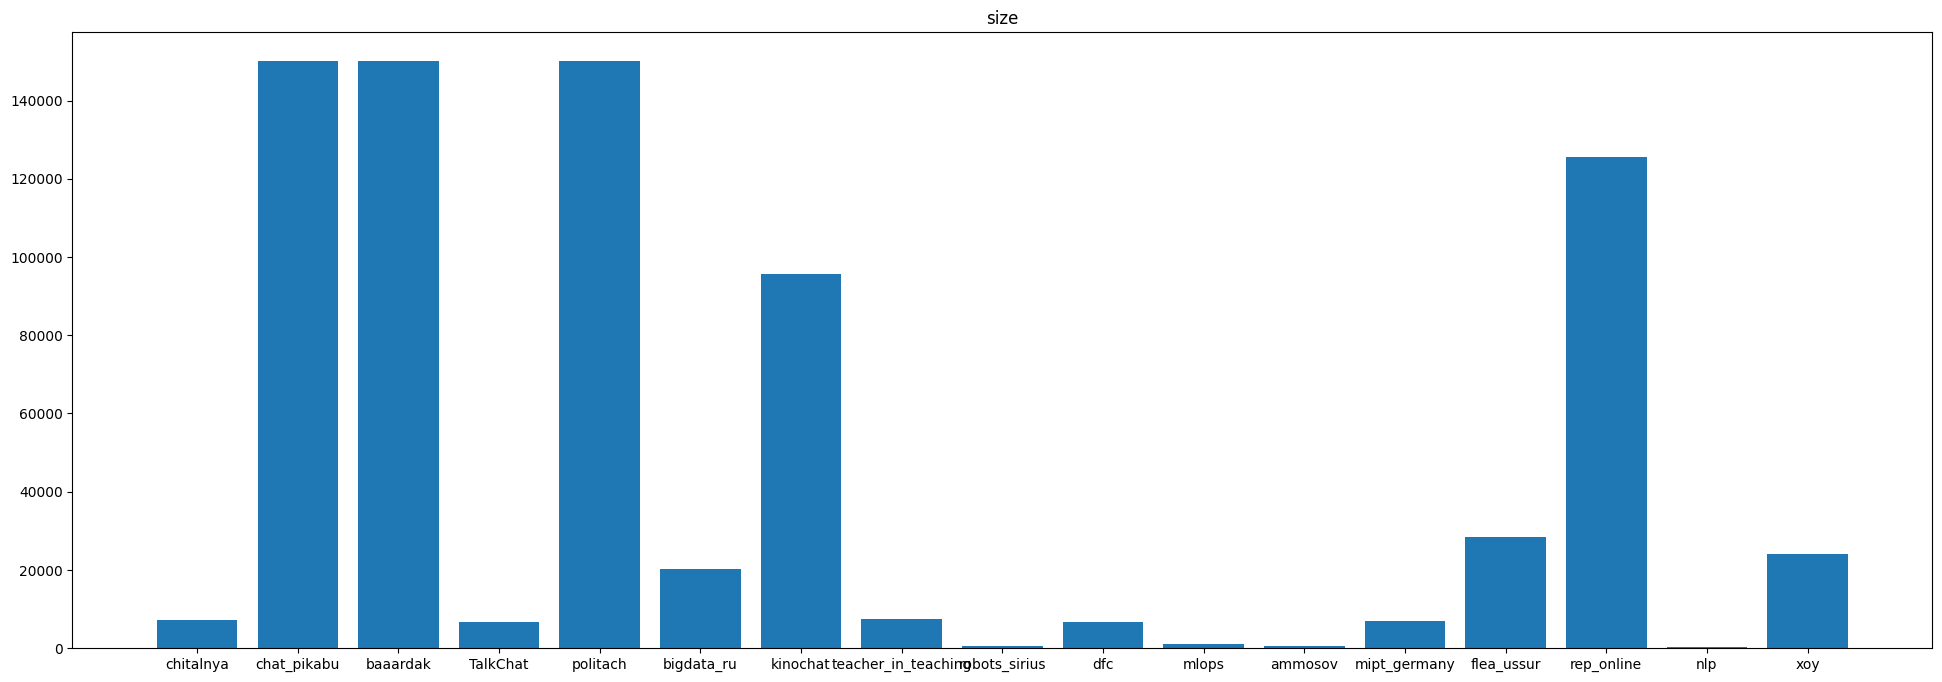

In [7]:
negative_ensemble.plot_lengths()

In [8]:
negative_dataset = negative_ensemble.merge()
negative_dataset = ApplyPreprocessors(negative_dataset, preprocessors=default_preprocessors)

### positive

In [9]:
positive_ensemble = DatasetEnsemble([])
positive_ensemble.extend(*parse_tg_chats("message_classification/positive_parsed_sites/", out_styled=True, sep="\",\n"))

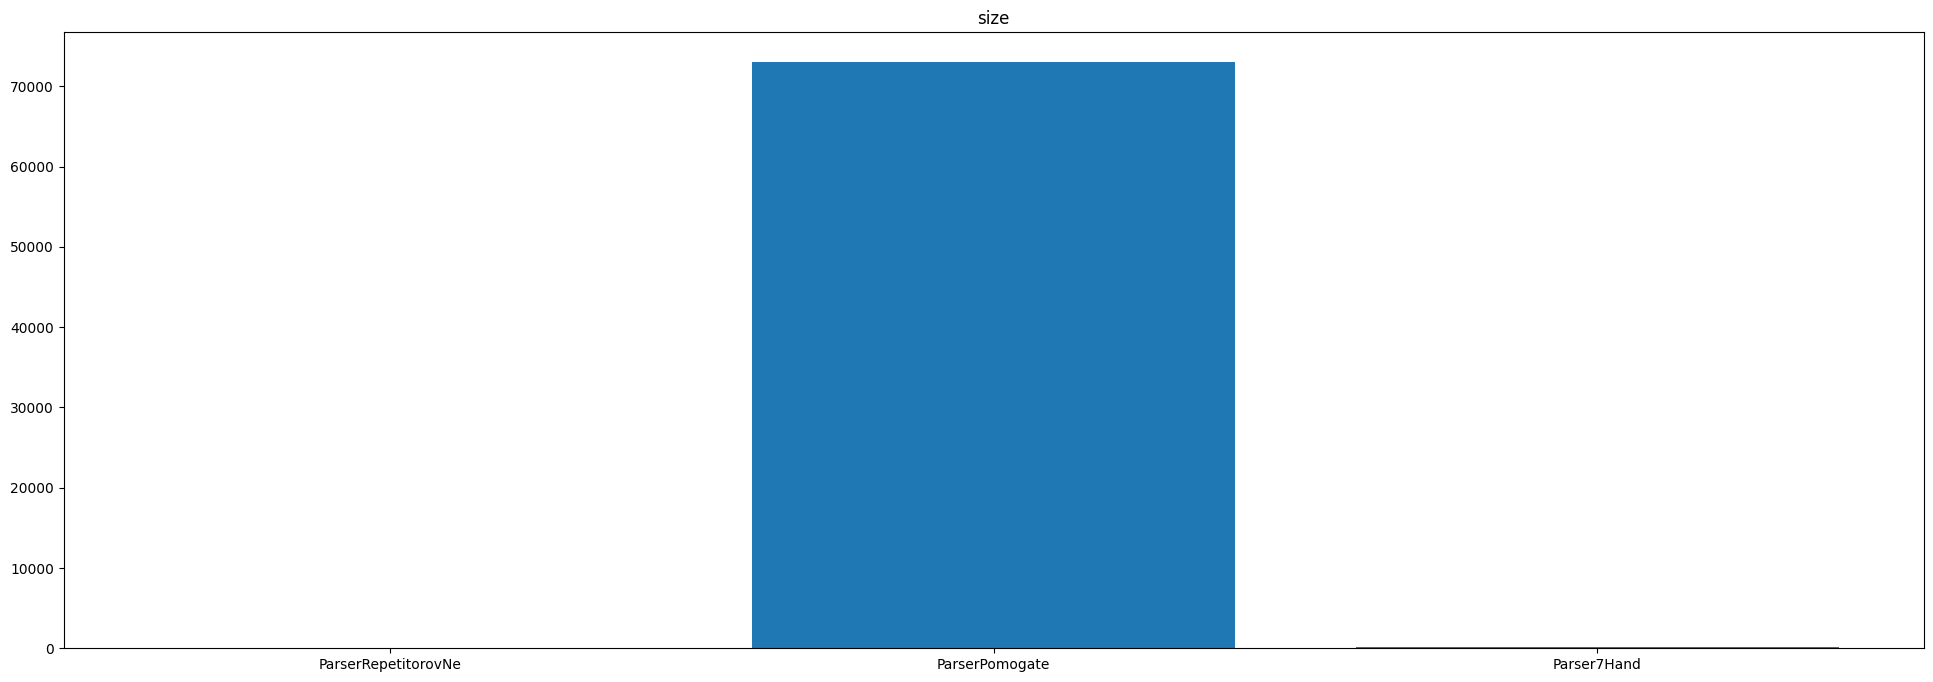

In [10]:
positive_ensemble.plot_lengths()

In [11]:
positive_dataset = positive_ensemble.merge()

def add_exclamation(array):
    return [" " + x for x in array + [x + "!" for x in array]]

def add_reversed(array):
    return array + [(x[1], x[0]) for x in array]

positive_dataset = spawn_clones(positive_dataset, len(negative_dataset) // len(positive_dataset))
negative_dataset = to_list_dataset(negative_dataset)
negative_dataset.clip(len(positive_dataset))

positive_dataset = ApplyPreprocessors(positive_dataset, preprocessors=default_preprocessors + [
    AddPrefixWithProbability(prefixes=add_exclamation([
        "Привет", "здравствуйте", "добрый день", "доброе утро", "добрый вечер", "рад вас видеть", "приветствую", "доброго времени суток",
         "привет", "Здравствуйте", "Добрый день", "Доброе утро", "Добрый вечер", "Рад вас видеть", "Приветствую", "Доброго времени Суток",
    ]), prob=0.1),
    ReplaceWithProbability(replacements=add_reversed([
        (" учитель ", " преподаватель "),
        (" учитель ", " репетитор "),
        (" преподаватель ", " репетитор "),
        (" учителя ", " преподавателя "),
        (" учителя ", " репетитора "),
        (" преподавателя ", " репетитора "),
        (" учителем ", " преподавателем "),
        (" учителем ", " репетитором "),
        (" преподавателем ", " репетитором "),
    ]), prob=0.05)
])

## train
### tokenizing

In [12]:
import torch
from torch import nn
from torch.optim.lr_scheduler import LinearLR
from nn.models.bert import HuggingFaceBertForClassification
from transformers import BertModel

from nn.models.tokenizers import HuggingFaceBertTokenizer
from nn.data.datasets import ApplyTokenizerToTupleElement
from nn.configs.train_configs import TrainConfig
from nn.train.trainers import DefaultTrainer
from nn.train.train import train
from nn.data.datasets import MergedDataset, ListDataset, merge_datasets
from nn.models.schedulers import DefaultScheduler, STLRScheduler

In [13]:
tokenizer = HuggingFaceBertTokenizer()
tokenizer.from_pretrained("cointegrated/rubert-tiny2")

print(len(positive_dataset), len(negative_dataset))

732530 732530


In [14]:
negative_dataset = MergedDataset([negative_dataset, ListDataset([0] * len(negative_dataset))])
positive_dataset = MergedDataset([positive_dataset, ListDataset([1] * len(positive_dataset))])
dataset = merge_datasets([positive_dataset, negative_dataset])

dataset = ApplyTokenizerToTupleElement(dataset, tokenizer, index=0)

### training

In [15]:
model = HuggingFaceBertForClassification(BertModel.from_pretrained("cointegrated/rubert-tiny2"), num_labels=2)

In [16]:
warmup_steps = 500
peak_step = warmup_steps // 3
train_steps = warmup_steps * 2

config = TrainConfig(
    epochs=1,
    steps=(warmup_steps + train_steps),
    batch_size=4,
    batches_accumulated=8,
    valid_share=0.1,
    device=torch.device("cuda:0"),
    text_logs=True, 
    log_interval=8,
)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=8e-6, weight_decay=0.08)

scheduler = STLRScheduler(
    optimizer=optimizer,
    peak_epoch=peak_step,
    warming_epochs=warmup_steps,
    peak_lr=[1e-5],
)

scheduler = DefaultScheduler(
    config=config,
    scheduler=scheduler,
    after_epoch=False,
)

trainer = DefaultTrainer(
    optimizer=optimizer,
    loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    config=config,
    scheduler=scheduler
)

In [18]:
train(
    model=model,
    dataset=dataset,
    config=config,
    trainer=trainer
)

batch: 8, loss: 0.6965268552303314
batch: 16, loss: 0.6937424018979073
batch: 24, loss: 0.6924224942922592
batch: 32, loss: 0.690941110253334
batch: 40, loss: 0.6941693797707558
batch: 48, loss: 0.6989776194095612
batch: 56, loss: 0.6854434758424759
batch: 64, loss: 0.6994755268096924
batch: 72, loss: 0.6863976418972015
batch: 80, loss: 0.6934535428881645
batch: 88, loss: 0.6882662028074265
batch: 96, loss: 0.6981514543294907
batch: 104, loss: 0.695056363940239
batch: 112, loss: 0.680630698800087
batch: 120, loss: 0.6918197646737099
batch: 128, loss: 0.6895315572619438
batch: 136, loss: 0.6833947375416756
batch: 144, loss: 0.6793661415576935
batch: 152, loss: 0.6754643246531487
batch: 160, loss: 0.6817515939474106
batch: 168, loss: 0.6745985969901085
batch: 176, loss: 0.6726542413234711
batch: 184, loss: 0.6794185861945152
batch: 192, loss: 0.6832188665866852
batch: 200, loss: 0.6677427738904953
batch: 208, loss: 0.6757961586117744
batch: 216, loss: 0.6566443368792534
batch: 224, loss:

In [19]:
torch.save(model.state_dict(), "/home/curlink/work/weights/torch/model.pt")